<a href="https://colab.research.google.com/github/caseymrobbins/bom_vea/blob/main/bom_vae_v11_comparison_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BOM-VAE vs β-VAE Comparison

**Hypothesis**: BOM achieves comparable or better results than β-VAE without requiring hyperparameter tuning.

**Adaptive squeeze rule**:
```
squeeze_amount = (s_min - 0.5) * k
```
- When s_min = 0.9: squeeze aggressively
- When s_min = 0.55: squeeze gently  
- When s_min ≤ 0.5: stop squeezing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [ ]:
# Shared VAE architecture
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
        )
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 256*4*4)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, 3, 2, 1, 1), nn.Sigmoid(),
        )

    def forward(self, x):
        h = self.enc(x).view(x.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)
        return self.dec(self.fc_dec(z).view(-1, 256, 4, 4)), mu, logvar

In [ ]:
# Data
class PadChannels:
    def __call__(self, x): return x.repeat(3, 1, 1)

transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor(), PadChannels()])
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)
print(f"Train: {len(train_loader)} batches, Test: {len(test_loader)} batches")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.57MB/s]

Train: 938 batches, Test: 157 batches


## Shared Metrics

In [ ]:
def compute_metrics(x, x_recon, mu, logvar):
    """Compute MSE, KL, and sharpness."""
    B = x.size(0)
    mse = F.mse_loss(x_recon, x, reduction='none').view(B, -1).mean(1)
    kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum(1)
    dx = torch.abs(x_recon[:,:,:,1:] - x_recon[:,:,:,:-1])
    dy = torch.abs(x_recon[:,:,1:,:] - x_recon[:,:,:-1,:])
    sharp = (dx.mean([1,2,3]) + dy.mean([1,2,3])) / 2
    return mse, kl, sharp


def evaluate(model, loader, device):
    """Evaluate model on test set."""
    model.eval()
    all_mse, all_kl, all_sharp = [], [], []

    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)
            x_recon, mu, logvar = model(x)
            mse, kl, sharp = compute_metrics(x, x_recon, mu, logvar)
            all_mse.extend(mse.cpu().numpy())
            all_kl.extend(kl.cpu().numpy())
            all_sharp.extend(sharp.cpu().numpy())

    return {
        'mse': np.mean(all_mse),
        'kl': np.mean(all_kl),
        'sharp': np.mean(all_sharp),
    }

---
## β-VAE Training

In [ ]:
def train_beta_vae(model, loader, device, beta, n_epochs=20):
    """
    Standard β-VAE training.
    Loss = MSE + β * KL
    """
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    history = []

    for epoch in range(1, n_epochs + 1):
        model.train()
        epoch_loss, epoch_mse, epoch_kl = [], [], []

        pbar = tqdm(loader, desc=f"β-VAE (β={beta}) Epoch {epoch}")
        for batch in pbar:
            x = batch[0].to(device)

            optimizer.zero_grad()
            x_recon, mu, logvar = model(x)

            mse, kl, sharp = compute_metrics(x, x_recon, mu, logvar)
            loss = mse.mean() + beta * kl.mean()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss.append(loss.item())
            epoch_mse.append(mse.mean().item())
            epoch_kl.append(kl.mean().item())

            history.append({
                'mse': mse.mean().item(),
                'kl': kl.mean().item(),
                'sharp': sharp.mean().item(),
            })

            pbar.set_postfix({'loss': f"{loss.item():.4f}", 'mse': f"{mse.mean().item():.4f}", 'kl': f"{kl.mean().item():.0f}"})

        print(f"  Epoch {epoch}: loss={np.mean(epoch_loss):.4f}, mse={np.mean(epoch_mse):.4f}, kl={np.mean(epoch_kl):.0f}")

    return history

---
## BOM-VAE Training with Adaptive Squeeze

In [ ]:
def regular_constraint_lower_better(value, floor):
    """Score for objectives where lower is better (MSE)."""
    return (floor - value) / floor


def regular_constraint_higher_better(value, ceiling):
    """Score for objectives where higher is better (sharpness)."""
    return value / ceiling


def box_constraint(value, floor_low, optimum, floor_high):
    """Score for objectives that need to stay in a range (KL)."""
    left = (value - floor_low) / (optimum - floor_low)
    right = (floor_high - value) / (floor_high - optimum)
    return torch.minimum(left, right)


def compute_bom_loss(x, x_recon, mu, logvar, mse_floor, kl_floor_low, kl_optimum, kl_floor_high, sharp_ceiling):
    """Compute BOM loss."""
    mse, kl, sharp = compute_metrics(x, x_recon, mu, logvar)

    mse_score = regular_constraint_lower_better(mse, mse_floor)
    kl_score = box_constraint(kl, kl_floor_low, kl_optimum, kl_floor_high)
    sharp_score = regular_constraint_higher_better(sharp, sharp_ceiling)

    scores = torch.stack([mse_score, kl_score, sharp_score], dim=1)
    s_min, min_idx = torch.min(scores, dim=1)

    violations = (s_min <= 0).sum().item()

    metrics = {
        'mse': mse.mean().item(),
        'kl': kl.mean().item(),
        'sharp': sharp.mean().item(),
        'mse_score': mse_score.mean().item(),
        'kl_score': kl_score.mean().item(),
        'sharp_score': sharp_score.mean().item(),
        's_min': s_min.mean().item(),
        'violations': violations,
    }

    if violations > 0:
        return None, metrics

    loss = -torch.log(s_min).mean()
    names = ['mse', 'kl', 'sharp']
    metrics['bottleneck'] = names[torch.bincount(min_idx, minlength=3).argmax().item()]
    metrics['loss'] = loss.item()

    return loss, metrics

In [ ]:
def calibrate_bom(model, loader, device, n_batches=50):
    """Calibrate BOM constraints based on model's current outputs."""
    model.train()  # Important: use train mode for BatchNorm
    all_mse, all_kl, all_sharp = [], [], []

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= n_batches: break
            x = batch[0].to(device)
            x_recon, mu, logvar = model(x)
            mse, kl, sharp = compute_metrics(x, x_recon, mu, logvar)
            all_mse.extend(mse.cpu().numpy())
            all_kl.extend(kl.cpu().numpy())
            all_sharp.extend(sharp.cpu().numpy())

    mse_arr = np.array(all_mse)
    kl_arr = np.array(all_kl)
    sharp_arr = np.array(all_sharp)

    params = {
        'mse_floor': mse_arr.max() * 2.0,
        'kl_floor_low': kl_arr.min() * 0.1,
        'kl_optimum': kl_arr.mean(),
        'kl_floor_high': kl_arr.max() * 50.0,  # Very loose initially
        'sharp_ceiling': sharp_arr.mean(),
    }

    print(f"Calibration: MSE={mse_arr.mean():.4f}, KL={kl_arr.mean():.1f}, Sharp={sharp_arr.mean():.4f}")
    print(f"Initial constraints: mse_floor={params['mse_floor']:.4f}, kl_box=[{params['kl_floor_low']:.1f}, {params['kl_optimum']:.1f}, {params['kl_floor_high']:.1f}]")

    return params

In [ ]:
def train_bom_vae(model, loader, device, n_epochs=20):
    """
    BOM-VAE training with adaptive squeeze.

    Squeeze rule: squeeze_amount = (s_min - 0.5) * k
    - s_min > 0.5: squeeze proportionally
    - s_min <= 0.5: don't squeeze
    """
    # Calibrate
    params = calibrate_bom(model, loader, device)

    mse_floor = params['mse_floor']
    kl_floor_low = params['kl_floor_low']
    kl_optimum = params['kl_optimum']
    kl_floor_high = params['kl_floor_high']
    sharp_ceiling = params['sharp_ceiling']

    # Targets
    target_kl_floor_low = 50
    target_kl_optimum = 80
    target_kl_floor_high = 150

    # Adaptive squeeze settings
    squeeze_k = 0.5  # Gain factor
    min_s_min_for_squeeze = 0.5
    squeeze_start_epoch = 3

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    history = []

    for epoch in range(1, n_epochs + 1):
        model.train()
        epoch_loss, epoch_s_min = [], []
        epoch_violations = 0

        pbar = tqdm(loader, desc=f"BOM-VAE Epoch {epoch}")
        for batch in pbar:
            x = batch[0].to(device)

            optimizer.zero_grad()
            x_recon, mu, logvar = model(x)

            loss, metrics = compute_bom_loss(
                x, x_recon, mu, logvar,
                mse_floor, kl_floor_low, kl_optimum, kl_floor_high, sharp_ceiling
            )

            if loss is not None:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                epoch_loss.append(metrics['loss'])
                epoch_s_min.append(metrics['s_min'])
            else:
                epoch_violations += metrics['violations']

            history.append(metrics)
            pbar.set_postfix({'s_min': f"{metrics['s_min']:.3f}", 'kl': f"{metrics['kl']:.0f}"})

        avg_s_min = np.mean(epoch_s_min) if epoch_s_min else 0
        print(f"  Epoch {epoch}: s_min={avg_s_min:.3f}, violations={epoch_violations}, mse={metrics['mse']:.4f}, kl={metrics['kl']:.0f}")
        print(f"    KL box: [{kl_floor_low:.1f}, {kl_optimum:.1f}, {kl_floor_high:.1f}]")

        # Adaptive squeeze
        if epoch >= squeeze_start_epoch and avg_s_min > min_s_min_for_squeeze:
            squeeze_amount = (avg_s_min - min_s_min_for_squeeze) * squeeze_k
            squeeze_factor = 1.0 - squeeze_amount  # e.g., s_min=0.9 -> factor=0.8
            squeeze_factor = max(0.5, squeeze_factor)  # Don't squeeze more than 50%

            print(f"    🔧 Squeeze: s_min={avg_s_min:.3f} -> factor={squeeze_factor:.2f}")

            # Squeeze MSE floor
            mse_floor *= squeeze_factor

            # Squeeze KL box toward targets
            if kl_floor_low < target_kl_floor_low:
                kl_floor_low += (target_kl_floor_low - kl_floor_low) * (1 - squeeze_factor)
            if kl_optimum < target_kl_optimum:
                kl_optimum += (target_kl_optimum - kl_optimum) * (1 - squeeze_factor)
            if kl_floor_high > target_kl_floor_high:
                kl_floor_high -= (kl_floor_high - target_kl_floor_high) * (1 - squeeze_factor)

    return history

---
## Run Comparison

In [ ]:
N_EPOCHS = 20
results = {}

In [ ]:
# β-VAE with different β values
betas = [0.0001, 0.001, 0.01, 0.1]

for beta in betas:
    print(f"\n{'='*60}")
    print(f"Training β-VAE with β={beta}")
    print('='*60)

    model = VAE(latent_dim=128).to(device)
    history = train_beta_vae(model, train_loader, device, beta=beta, n_epochs=N_EPOCHS)
    test_metrics = evaluate(model, test_loader, device)

    results[f'beta_{beta}'] = {
        'model': model,
        'history': history,
        'test': test_metrics,
    }

    print(f"\nTest results: MSE={test_metrics['mse']:.4f}, KL={test_metrics['kl']:.1f}, Sharp={test_metrics['sharp']:.4f}")


Training β-VAE with β=0.0001


β-VAE (β=0.0001) Epoch 1: 100%|██████████| 938/938 [00:12<00:00, 76.10it/s, loss=0.0105, mse=0.0056, kl=49]


  Epoch 1: loss=0.0210, mse=0.0149, kl=61


β-VAE (β=0.0001) Epoch 2: 100%|██████████| 938/938 [00:10<00:00, 90.21it/s, loss=0.0108, mse=0.0053, kl=56]


  Epoch 2: loss=0.0106, mse=0.0053, kl=53


β-VAE (β=0.0001) Epoch 3: 100%|██████████| 938/938 [00:10<00:00, 90.52it/s, loss=0.0095, mse=0.0045, kl=51]


  Epoch 3: loss=0.0099, mse=0.0048, kl=52


β-VAE (β=0.0001) Epoch 4: 100%|██████████| 938/938 [00:10<00:00, 89.78it/s, loss=0.0097, mse=0.0044, kl=53]


  Epoch 4: loss=0.0096, mse=0.0045, kl=51


β-VAE (β=0.0001) Epoch 5: 100%|██████████| 938/938 [00:10<00:00, 91.40it/s, loss=0.0087, mse=0.0039, kl=49]


  Epoch 5: loss=0.0093, mse=0.0043, kl=50


β-VAE (β=0.0001) Epoch 6: 100%|██████████| 938/938 [00:10<00:00, 91.23it/s, loss=0.0086, mse=0.0037, kl=49]


  Epoch 6: loss=0.0092, mse=0.0042, kl=49


β-VAE (β=0.0001) Epoch 7: 100%|██████████| 938/938 [00:10<00:00, 91.32it/s, loss=0.0098, mse=0.0046, kl=52]


  Epoch 7: loss=0.0090, mse=0.0041, kl=49


β-VAE (β=0.0001) Epoch 8: 100%|██████████| 938/938 [00:10<00:00, 92.43it/s, loss=0.0085, mse=0.0038, kl=47]


  Epoch 8: loss=0.0089, mse=0.0040, kl=49


β-VAE (β=0.0001) Epoch 9: 100%|██████████| 938/938 [00:10<00:00, 90.14it/s, loss=0.0086, mse=0.0040, kl=46]


  Epoch 9: loss=0.0088, mse=0.0039, kl=48


β-VAE (β=0.0001) Epoch 10: 100%|██████████| 938/938 [00:10<00:00, 91.15it/s, loss=0.0096, mse=0.0042, kl=54]


  Epoch 10: loss=0.0087, mse=0.0039, kl=48


β-VAE (β=0.0001) Epoch 11: 100%|██████████| 938/938 [00:10<00:00, 91.35it/s, loss=0.0087, mse=0.0038, kl=49]


  Epoch 11: loss=0.0086, mse=0.0038, kl=48


β-VAE (β=0.0001) Epoch 12: 100%|██████████| 938/938 [00:10<00:00, 93.32it/s, loss=0.0086, mse=0.0039, kl=47]


  Epoch 12: loss=0.0085, mse=0.0038, kl=47


β-VAE (β=0.0001) Epoch 13: 100%|██████████| 938/938 [00:10<00:00, 90.65it/s, loss=0.0082, mse=0.0035, kl=47]


  Epoch 13: loss=0.0084, mse=0.0037, kl=47


β-VAE (β=0.0001) Epoch 14: 100%|██████████| 938/938 [00:10<00:00, 92.44it/s, loss=0.0078, mse=0.0033, kl=45]


  Epoch 14: loss=0.0084, mse=0.0037, kl=47


β-VAE (β=0.0001) Epoch 15: 100%|██████████| 938/938 [00:10<00:00, 91.55it/s, loss=0.0074, mse=0.0031, kl=43]


  Epoch 15: loss=0.0083, mse=0.0037, kl=47


β-VAE (β=0.0001) Epoch 16: 100%|██████████| 938/938 [00:10<00:00, 92.02it/s, loss=0.0077, mse=0.0032, kl=45]


  Epoch 16: loss=0.0083, mse=0.0036, kl=46


β-VAE (β=0.0001) Epoch 17: 100%|██████████| 938/938 [00:10<00:00, 92.92it/s, loss=0.0078, mse=0.0032, kl=46]


  Epoch 17: loss=0.0082, mse=0.0036, kl=46


β-VAE (β=0.0001) Epoch 18: 100%|██████████| 938/938 [00:10<00:00, 91.83it/s, loss=0.0085, mse=0.0038, kl=47]


  Epoch 18: loss=0.0082, mse=0.0036, kl=46


β-VAE (β=0.0001) Epoch 19: 100%|██████████| 938/938 [00:10<00:00, 91.78it/s, loss=0.0080, mse=0.0038, kl=42]


  Epoch 19: loss=0.0081, mse=0.0035, kl=46


β-VAE (β=0.0001) Epoch 20: 100%|██████████| 938/938 [00:10<00:00, 91.86it/s, loss=0.0085, mse=0.0038, kl=47]


  Epoch 20: loss=0.0081, mse=0.0035, kl=46

Test results: MSE=0.0035, KL=45.1, Sharp=0.0264

Training β-VAE with β=0.001


β-VAE (β=0.001) Epoch 1: 100%|██████████| 938/938 [00:10<00:00, 91.77it/s, loss=0.0381, mse=0.0229, kl=15]


  Epoch 1: loss=0.0451, mse=0.0324, kl=13


β-VAE (β=0.001) Epoch 2: 100%|██████████| 938/938 [00:10<00:00, 90.54it/s, loss=0.0292, mse=0.0160, kl=13]


  Epoch 2: loss=0.0321, mse=0.0193, kl=13


β-VAE (β=0.001) Epoch 3: 100%|██████████| 938/938 [00:10<00:00, 91.27it/s, loss=0.0284, mse=0.0162, kl=12]


  Epoch 3: loss=0.0306, mse=0.0178, kl=13


β-VAE (β=0.001) Epoch 4: 100%|██████████| 938/938 [00:10<00:00, 91.56it/s, loss=0.0285, mse=0.0158, kl=13]


  Epoch 4: loss=0.0296, mse=0.0169, kl=13


β-VAE (β=0.001) Epoch 5: 100%|██████████| 938/938 [00:10<00:00, 90.00it/s, loss=0.0319, mse=0.0179, kl=14]


  Epoch 5: loss=0.0291, mse=0.0163, kl=13


β-VAE (β=0.001) Epoch 6: 100%|██████████| 938/938 [00:10<00:00, 90.81it/s, loss=0.0290, mse=0.0156, kl=13]


  Epoch 6: loss=0.0286, mse=0.0159, kl=13


β-VAE (β=0.001) Epoch 7: 100%|██████████| 938/938 [00:10<00:00, 90.67it/s, loss=0.0274, mse=0.0152, kl=12]


  Epoch 7: loss=0.0282, mse=0.0156, kl=13


β-VAE (β=0.001) Epoch 8: 100%|██████████| 938/938 [00:10<00:00, 92.00it/s, loss=0.0271, mse=0.0149, kl=12]


  Epoch 8: loss=0.0280, mse=0.0153, kl=13


β-VAE (β=0.001) Epoch 9: 100%|██████████| 938/938 [00:10<00:00, 91.91it/s, loss=0.0272, mse=0.0143, kl=13]


  Epoch 9: loss=0.0278, mse=0.0151, kl=13


β-VAE (β=0.001) Epoch 10: 100%|██████████| 938/938 [00:10<00:00, 91.93it/s, loss=0.0275, mse=0.0148, kl=13]


  Epoch 10: loss=0.0276, mse=0.0149, kl=13


β-VAE (β=0.001) Epoch 11: 100%|██████████| 938/938 [00:10<00:00, 91.87it/s, loss=0.0255, mse=0.0133, kl=12]


  Epoch 11: loss=0.0274, mse=0.0148, kl=13


β-VAE (β=0.001) Epoch 12: 100%|██████████| 938/938 [00:10<00:00, 91.69it/s, loss=0.0286, mse=0.0156, kl=13]


  Epoch 12: loss=0.0273, mse=0.0146, kl=13


β-VAE (β=0.001) Epoch 13: 100%|██████████| 938/938 [00:10<00:00, 91.29it/s, loss=0.0240, mse=0.0125, kl=12]


  Epoch 13: loss=0.0272, mse=0.0145, kl=13


β-VAE (β=0.001) Epoch 14: 100%|██████████| 938/938 [00:10<00:00, 92.09it/s, loss=0.0290, mse=0.0159, kl=13]


  Epoch 14: loss=0.0270, mse=0.0144, kl=13


β-VAE (β=0.001) Epoch 15: 100%|██████████| 938/938 [00:10<00:00, 89.46it/s, loss=0.0295, mse=0.0168, kl=13]


  Epoch 15: loss=0.0270, mse=0.0143, kl=13


β-VAE (β=0.001) Epoch 16: 100%|██████████| 938/938 [00:10<00:00, 92.61it/s, loss=0.0245, mse=0.0124, kl=12]


  Epoch 16: loss=0.0268, mse=0.0142, kl=13


β-VAE (β=0.001) Epoch 17: 100%|██████████| 938/938 [00:10<00:00, 91.32it/s, loss=0.0285, mse=0.0153, kl=13]


  Epoch 17: loss=0.0267, mse=0.0141, kl=13


β-VAE (β=0.001) Epoch 18: 100%|██████████| 938/938 [00:10<00:00, 91.75it/s, loss=0.0282, mse=0.0152, kl=13]


  Epoch 18: loss=0.0267, mse=0.0141, kl=13


β-VAE (β=0.001) Epoch 19: 100%|██████████| 938/938 [00:10<00:00, 92.74it/s, loss=0.0269, mse=0.0141, kl=13]


  Epoch 19: loss=0.0266, mse=0.0140, kl=13


β-VAE (β=0.001) Epoch 20: 100%|██████████| 938/938 [00:10<00:00, 92.11it/s, loss=0.0244, mse=0.0118, kl=13]

  Epoch 20: loss=0.0265, mse=0.0139, kl=13



Test results: MSE=0.0133, KL=13.1, Sharp=0.0239

Training β-VAE with β=0.01


β-VAE (β=0.01) Epoch 1: 100%|██████████| 938/938 [00:10<00:00, 91.30it/s, loss=0.0570, mse=0.0554, kl=0]


  Epoch 1: loss=0.0694, mse=0.0636, kl=1


β-VAE (β=0.01) Epoch 2: 100%|██████████| 938/938 [00:10<00:00, 91.10it/s, loss=0.0558, mse=0.0550, kl=0]


  Epoch 2: loss=0.0579, mse=0.0562, kl=0


β-VAE (β=0.01) Epoch 3: 100%|██████████| 938/938 [00:10<00:00, 91.58it/s, loss=0.0593, mse=0.0584, kl=0]


  Epoch 3: loss=0.0571, mse=0.0560, kl=0


β-VAE (β=0.01) Epoch 4: 100%|██████████| 938/938 [00:10<00:00, 90.22it/s, loss=0.0625, mse=0.0611, kl=0]


  Epoch 4: loss=0.0569, mse=0.0559, kl=0


β-VAE (β=0.01) Epoch 5: 100%|██████████| 938/938 [00:10<00:00, 90.85it/s, loss=0.0598, mse=0.0588, kl=0]


  Epoch 5: loss=0.0568, mse=0.0559, kl=0


β-VAE (β=0.01) Epoch 6: 100%|██████████| 938/938 [00:10<00:00, 91.54it/s, loss=0.0589, mse=0.0580, kl=0]


  Epoch 6: loss=0.0566, mse=0.0559, kl=0


β-VAE (β=0.01) Epoch 7: 100%|██████████| 938/938 [00:10<00:00, 91.29it/s, loss=0.0605, mse=0.0599, kl=0]


  Epoch 7: loss=0.0566, mse=0.0558, kl=0


β-VAE (β=0.01) Epoch 8: 100%|██████████| 938/938 [00:10<00:00, 91.19it/s, loss=0.0557, mse=0.0552, kl=0]


  Epoch 8: loss=0.0565, mse=0.0558, kl=0


β-VAE (β=0.01) Epoch 9: 100%|██████████| 938/938 [00:10<00:00, 91.85it/s, loss=0.0552, mse=0.0547, kl=0]


  Epoch 9: loss=0.0565, mse=0.0557, kl=0


β-VAE (β=0.01) Epoch 10: 100%|██████████| 938/938 [00:10<00:00, 91.72it/s, loss=0.0553, mse=0.0546, kl=0]


  Epoch 10: loss=0.0565, mse=0.0557, kl=0


β-VAE (β=0.01) Epoch 11: 100%|██████████| 938/938 [00:10<00:00, 90.60it/s, loss=0.0563, mse=0.0553, kl=0]


  Epoch 11: loss=0.0564, mse=0.0556, kl=0


β-VAE (β=0.01) Epoch 12: 100%|██████████| 938/938 [00:10<00:00, 91.43it/s, loss=0.0636, mse=0.0622, kl=0]


  Epoch 12: loss=0.0564, mse=0.0556, kl=0


β-VAE (β=0.01) Epoch 13: 100%|██████████| 938/938 [00:10<00:00, 90.89it/s, loss=0.0612, mse=0.0601, kl=0]


  Epoch 13: loss=0.0564, mse=0.0556, kl=0


β-VAE (β=0.01) Epoch 14: 100%|██████████| 938/938 [00:10<00:00, 91.11it/s, loss=0.0558, mse=0.0553, kl=0]


  Epoch 14: loss=0.0564, mse=0.0555, kl=0


β-VAE (β=0.01) Epoch 15: 100%|██████████| 938/938 [00:10<00:00, 92.16it/s, loss=0.0545, mse=0.0542, kl=0]


  Epoch 15: loss=0.0564, mse=0.0555, kl=0


β-VAE (β=0.01) Epoch 16: 100%|██████████| 938/938 [00:10<00:00, 91.72it/s, loss=0.0593, mse=0.0580, kl=0]


  Epoch 16: loss=0.0564, mse=0.0554, kl=0


β-VAE (β=0.01) Epoch 17: 100%|██████████| 938/938 [00:10<00:00, 90.55it/s, loss=0.0596, mse=0.0588, kl=0]


  Epoch 17: loss=0.0564, mse=0.0554, kl=0


β-VAE (β=0.01) Epoch 18: 100%|██████████| 938/938 [00:10<00:00, 92.54it/s, loss=0.0624, mse=0.0615, kl=0]


  Epoch 18: loss=0.0564, mse=0.0554, kl=0


β-VAE (β=0.01) Epoch 19: 100%|██████████| 938/938 [00:10<00:00, 91.24it/s, loss=0.0549, mse=0.0539, kl=0]


  Epoch 19: loss=0.0564, mse=0.0555, kl=0


β-VAE (β=0.01) Epoch 20: 100%|██████████| 938/938 [00:10<00:00, 91.13it/s, loss=0.0548, mse=0.0540, kl=0]

  Epoch 20: loss=0.0564, mse=0.0554, kl=0



Test results: MSE=0.0558, KL=0.1, Sharp=0.0109

Training β-VAE with β=0.1


β-VAE (β=0.1) Epoch 1: 100%|██████████| 938/938 [00:10<00:00, 91.81it/s, loss=0.0582, mse=0.0509, kl=0]


  Epoch 1: loss=0.1165, mse=0.0619, kl=1


β-VAE (β=0.1) Epoch 2: 100%|██████████| 938/938 [00:10<00:00, 92.14it/s, loss=0.0545, mse=0.0541, kl=0]


  Epoch 2: loss=0.0596, mse=0.0566, kl=0


β-VAE (β=0.1) Epoch 3: 100%|██████████| 938/938 [00:10<00:00, 91.61it/s, loss=0.0585, mse=0.0583, kl=0]


  Epoch 3: loss=0.0576, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 4: 100%|██████████| 938/938 [00:10<00:00, 90.11it/s, loss=0.0573, mse=0.0571, kl=0]


  Epoch 4: loss=0.0568, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 5: 100%|██████████| 938/938 [00:10<00:00, 91.39it/s, loss=0.0539, mse=0.0537, kl=0]


  Epoch 5: loss=0.0570, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 6: 100%|██████████| 938/938 [00:10<00:00, 92.76it/s, loss=0.0581, mse=0.0573, kl=0]


  Epoch 6: loss=0.0568, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 7: 100%|██████████| 938/938 [00:10<00:00, 90.15it/s, loss=0.0523, mse=0.0523, kl=0]


  Epoch 7: loss=0.0566, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 8: 100%|██████████| 938/938 [00:10<00:00, 91.20it/s, loss=0.0546, mse=0.0546, kl=0]


  Epoch 8: loss=0.0566, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 9: 100%|██████████| 938/938 [00:10<00:00, 90.03it/s, loss=0.0514, mse=0.0514, kl=0]


  Epoch 9: loss=0.0565, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 10: 100%|██████████| 938/938 [00:10<00:00, 89.50it/s, loss=0.0545, mse=0.0544, kl=0]


  Epoch 10: loss=0.0565, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 11: 100%|██████████| 938/938 [00:10<00:00, 89.07it/s, loss=0.0612, mse=0.0611, kl=0]


  Epoch 11: loss=0.0565, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 12: 100%|██████████| 938/938 [00:10<00:00, 89.85it/s, loss=0.0610, mse=0.0609, kl=0]


  Epoch 12: loss=0.0575, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 13: 100%|██████████| 938/938 [00:10<00:00, 88.29it/s, loss=0.0529, mse=0.0529, kl=0]


  Epoch 13: loss=0.0565, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 14: 100%|██████████| 938/938 [00:10<00:00, 89.59it/s, loss=0.0563, mse=0.0563, kl=0]


  Epoch 14: loss=0.0565, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 15: 100%|██████████| 938/938 [00:10<00:00, 89.82it/s, loss=0.0596, mse=0.0596, kl=0]


  Epoch 15: loss=0.0565, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 16: 100%|██████████| 938/938 [00:10<00:00, 90.02it/s, loss=0.0562, mse=0.0562, kl=0]


  Epoch 16: loss=0.0565, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 17: 100%|██████████| 938/938 [00:10<00:00, 91.05it/s, loss=0.0577, mse=0.0577, kl=0]


  Epoch 17: loss=0.0565, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 18: 100%|██████████| 938/938 [00:10<00:00, 91.13it/s, loss=0.0540, mse=0.0540, kl=0]


  Epoch 18: loss=0.0565, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 19: 100%|██████████| 938/938 [00:10<00:00, 90.53it/s, loss=0.0504, mse=0.0504, kl=0]


  Epoch 19: loss=0.0565, mse=0.0565, kl=0


β-VAE (β=0.1) Epoch 20: 100%|██████████| 938/938 [00:10<00:00, 90.28it/s, loss=0.0525, mse=0.0525, kl=0]

  Epoch 20: loss=0.0565, mse=0.0565, kl=0



Test results: MSE=0.0567, KL=0.0, Sharp=0.0105


In [ ]:
# BOM-VAE
print(f"\n{'='*60}")
print(f"Training BOM-VAE (no β tuning required)")
print('='*60)

model_bom = VAE(latent_dim=128).to(device)
history_bom = train_bom_vae(model_bom, train_loader, device, n_epochs=N_EPOCHS)
test_metrics_bom = evaluate(model_bom, test_loader, device)

results['bom'] = {
    'model': model_bom,
    'history': history_bom,
    'test': test_metrics_bom,
}

print(f"\nTest results: MSE={test_metrics_bom['mse']:.4f}, KL={test_metrics_bom['kl']:.1f}, Sharp={test_metrics_bom['sharp']:.4f}")


Training BOM-VAE (no β tuning required)
Calibration: MSE=0.2300, KL=17.2, Sharp=0.1543
Initial constraints: mse_floor=0.5001, kl_box=[0.5, 17.2, 1732.7]


BOM-VAE Epoch 1: 100%|██████████| 938/938 [00:11<00:00, 78.61it/s, s_min=0.958, kl=81]


  Epoch 1: s_min=0.937, violations=1, mse=0.0212, kl=81
    KL box: [0.5, 17.2, 1732.7]


BOM-VAE Epoch 2: 100%|██████████| 938/938 [00:11<00:00, 82.25it/s, s_min=0.961, kl=81]


  Epoch 2: s_min=0.959, violations=0, mse=0.0192, kl=81
    KL box: [0.5, 17.2, 1732.7]


BOM-VAE Epoch 3: 100%|██████████| 938/938 [00:11<00:00, 82.68it/s, s_min=0.969, kl=67]


  Epoch 3: s_min=0.966, violations=0, mse=0.0147, kl=67
    KL box: [0.5, 17.2, 1732.7]
    🔧 Squeeze: s_min=0.966 -> factor=0.77


BOM-VAE Epoch 4: 100%|██████████| 938/938 [00:11<00:00, 82.29it/s, s_min=0.965, kl=74]


  Epoch 4: s_min=0.964, violations=0, mse=0.0134, kl=74
    KL box: [12.0, 31.8, 1364.1]
    🔧 Squeeze: s_min=0.964 -> factor=0.77


BOM-VAE Epoch 5: 100%|██████████| 938/938 [00:11<00:00, 81.31it/s, s_min=0.958, kl=83]


  Epoch 5: s_min=0.957, violations=0, mse=0.0119, kl=83
    KL box: [20.8, 43.0, 1082.5]
    🔧 Squeeze: s_min=0.957 -> factor=0.77


BOM-VAE Epoch 6: 100%|██████████| 938/938 [00:11<00:00, 78.71it/s, s_min=0.947, kl=87]


  Epoch 6: s_min=0.949, violations=0, mse=0.0119, kl=87
    KL box: [27.5, 51.5, 869.3]
    🔧 Squeeze: s_min=0.949 -> factor=0.78


BOM-VAE Epoch 7: 100%|██████████| 938/938 [00:11<00:00, 81.48it/s, s_min=0.936, kl=90]


  Epoch 7: s_min=0.937, violations=0, mse=0.0112, kl=90
    KL box: [32.6, 57.9, 708.0]
    🔧 Squeeze: s_min=0.937 -> factor=0.78


BOM-VAE Epoch 8: 100%|██████████| 938/938 [00:11<00:00, 79.93it/s, s_min=0.926, kl=97]


  Epoch 8: s_min=0.924, violations=0, mse=0.0102, kl=97
    KL box: [36.4, 62.7, 586.0]
    🔧 Squeeze: s_min=0.924 -> factor=0.79


BOM-VAE Epoch 9: 100%|██████████| 938/938 [00:11<00:00, 79.18it/s, s_min=0.906, kl=99]


  Epoch 9: s_min=0.908, violations=0, mse=0.0102, kl=99
    KL box: [39.3, 66.4, 493.6]
    🔧 Squeeze: s_min=0.908 -> factor=0.80


BOM-VAE Epoch 10: 100%|██████████| 938/938 [00:11<00:00, 78.85it/s, s_min=0.892, kl=102]


  Epoch 10: s_min=0.890, violations=0, mse=0.0093, kl=102
    KL box: [41.4, 69.2, 423.5]
    🔧 Squeeze: s_min=0.890 -> factor=0.80


BOM-VAE Epoch 11: 100%|██████████| 938/938 [00:12<00:00, 77.70it/s, s_min=0.869, kl=104]


  Epoch 11: s_min=0.870, violations=0, mse=0.0090, kl=104
    KL box: [43.1, 71.3, 370.1]
    🔧 Squeeze: s_min=0.870 -> factor=0.81


BOM-VAE Epoch 12: 100%|██████████| 938/938 [00:11<00:00, 78.87it/s, s_min=0.846, kl=106]


  Epoch 12: s_min=0.850, violations=0, mse=0.0087, kl=106
    KL box: [44.4, 72.9, 329.4]
    🔧 Squeeze: s_min=0.850 -> factor=0.83


BOM-VAE Epoch 13: 100%|██████████| 938/938 [00:11<00:00, 82.14it/s, s_min=0.829, kl=110]


  Epoch 13: s_min=0.828, violations=0, mse=0.0079, kl=110
    KL box: [45.4, 74.1, 298.0]
    🔧 Squeeze: s_min=0.828 -> factor=0.84


BOM-VAE Epoch 14: 100%|██████████| 938/938 [00:11<00:00, 80.53it/s, s_min=0.808, kl=106]


  Epoch 14: s_min=0.806, violations=0, mse=0.0074, kl=106
    KL box: [46.1, 75.1, 273.7]
    🔧 Squeeze: s_min=0.806 -> factor=0.85


BOM-VAE Epoch 15: 100%|██████████| 938/938 [00:11<00:00, 80.87it/s, s_min=0.785, kl=110]


  Epoch 15: s_min=0.784, violations=0, mse=0.0070, kl=110
    KL box: [46.7, 75.8, 254.8]
    🔧 Squeeze: s_min=0.784 -> factor=0.86


BOM-VAE Epoch 16: 100%|██████████| 938/938 [00:11<00:00, 80.95it/s, s_min=0.756, kl=111]


  Epoch 16: s_min=0.762, violations=0, mse=0.0069, kl=111
    KL box: [47.2, 76.4, 239.9]
    🔧 Squeeze: s_min=0.762 -> factor=0.87


BOM-VAE Epoch 17: 100%|██████████| 938/938 [00:11<00:00, 82.01it/s, s_min=0.740, kl=111]


  Epoch 17: s_min=0.742, violations=0, mse=0.0062, kl=111
    KL box: [47.6, 76.9, 228.1]
    🔧 Squeeze: s_min=0.742 -> factor=0.88


BOM-VAE Epoch 18: 100%|██████████| 938/938 [00:11<00:00, 82.17it/s, s_min=0.717, kl=113]


  Epoch 18: s_min=0.722, violations=0, mse=0.0061, kl=113
    KL box: [47.9, 77.3, 218.7]
    🔧 Squeeze: s_min=0.722 -> factor=0.89


BOM-VAE Epoch 19: 100%|██████████| 938/938 [00:11<00:00, 82.59it/s, s_min=0.707, kl=114]


  Epoch 19: s_min=0.704, violations=0, mse=0.0056, kl=114
    KL box: [48.1, 77.6, 211.1]
    🔧 Squeeze: s_min=0.704 -> factor=0.90


BOM-VAE Epoch 20: 100%|██████████| 938/938 [00:11<00:00, 81.84it/s, s_min=0.691, kl=114]

  Epoch 20: s_min=0.686, violations=0, mse=0.0053, kl=114
    KL box: [48.3, 77.8, 204.8]
    🔧 Squeeze: s_min=0.686 -> factor=0.91



Test results: MSE=0.0054, KL=113.0, Sharp=0.1082


---
## Results Comparison

In [ ]:
# Summary table
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"{'Method':<20} {'MSE':>10} {'KL':>10} {'Sharpness':>12}")
print("-"*70)

for name, data in results.items():
    t = data['test']
    print(f"{name:<20} {t['mse']:>10.4f} {t['kl']:>10.1f} {t['sharp']:>12.4f}")

print("-"*70)


FINAL RESULTS
Method                      MSE         KL    Sharpness
----------------------------------------------------------------------
beta_0.0001              0.0035       45.1       0.0264
beta_0.001               0.0133       13.1       0.0239
beta_0.01                0.0558        0.1       0.0109
beta_0.1                 0.0567        0.0       0.0105
bom                      0.0054      113.0       0.1082
----------------------------------------------------------------------


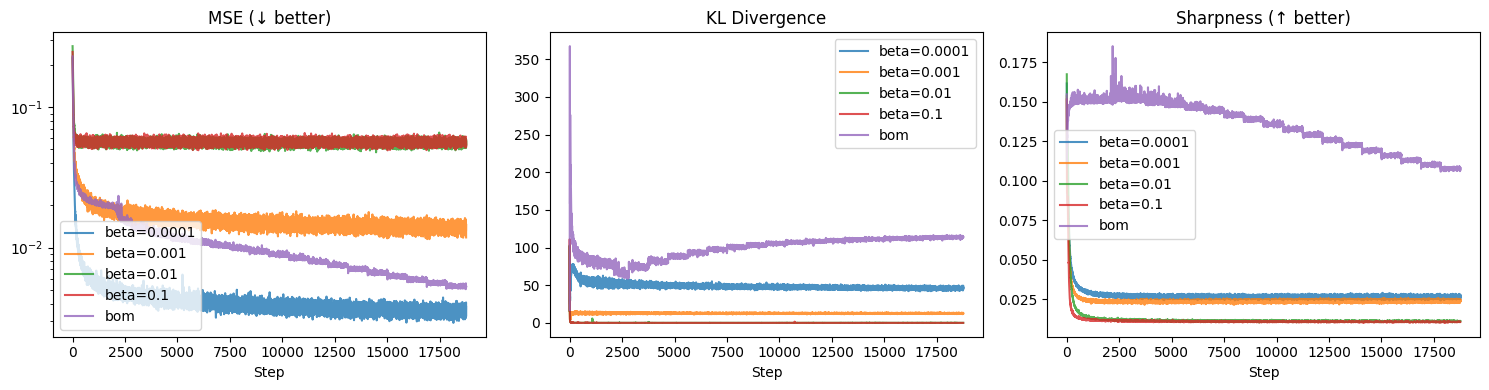

In [ ]:
# Training curves comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for name, data in results.items():
    h = data['history']
    label = name.replace('_', '=')

    axes[0].plot([x['mse'] for x in h], label=label, alpha=0.8)
    axes[1].plot([x['kl'] for x in h], label=label, alpha=0.8)
    axes[2].plot([x['sharp'] for x in h], label=label, alpha=0.8)

axes[0].set_title('MSE (↓ better)')
axes[0].set_xlabel('Step')
axes[0].legend()
axes[0].set_yscale('log')

axes[1].set_title('KL Divergence')
axes[1].set_xlabel('Step')
axes[1].legend()

axes[2].set_title('Sharpness (↑ better)')
axes[2].set_xlabel('Step')
axes[2].legend()

plt.tight_layout()
plt.savefig('training_comparison.png', dpi=150)
plt.show()

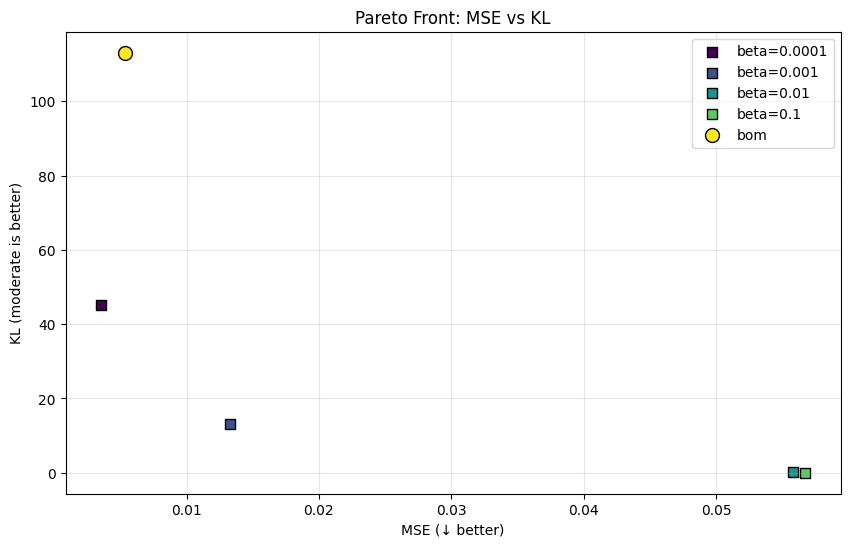

In [ ]:
# Pareto plot: MSE vs KL
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

for (name, data), color in zip(results.items(), colors):
    t = data['test']
    marker = 's' if 'beta' in name else 'o'
    size = 100 if 'bom' in name else 60
    plt.scatter(t['mse'], t['kl'], s=size, c=[color], marker=marker, label=name.replace('_', '='), edgecolors='black')

plt.xlabel('MSE (↓ better)')
plt.ylabel('KL (moderate is better)')
plt.title('Pareto Front: MSE vs KL')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('pareto_comparison.png', dpi=150)
plt.show()

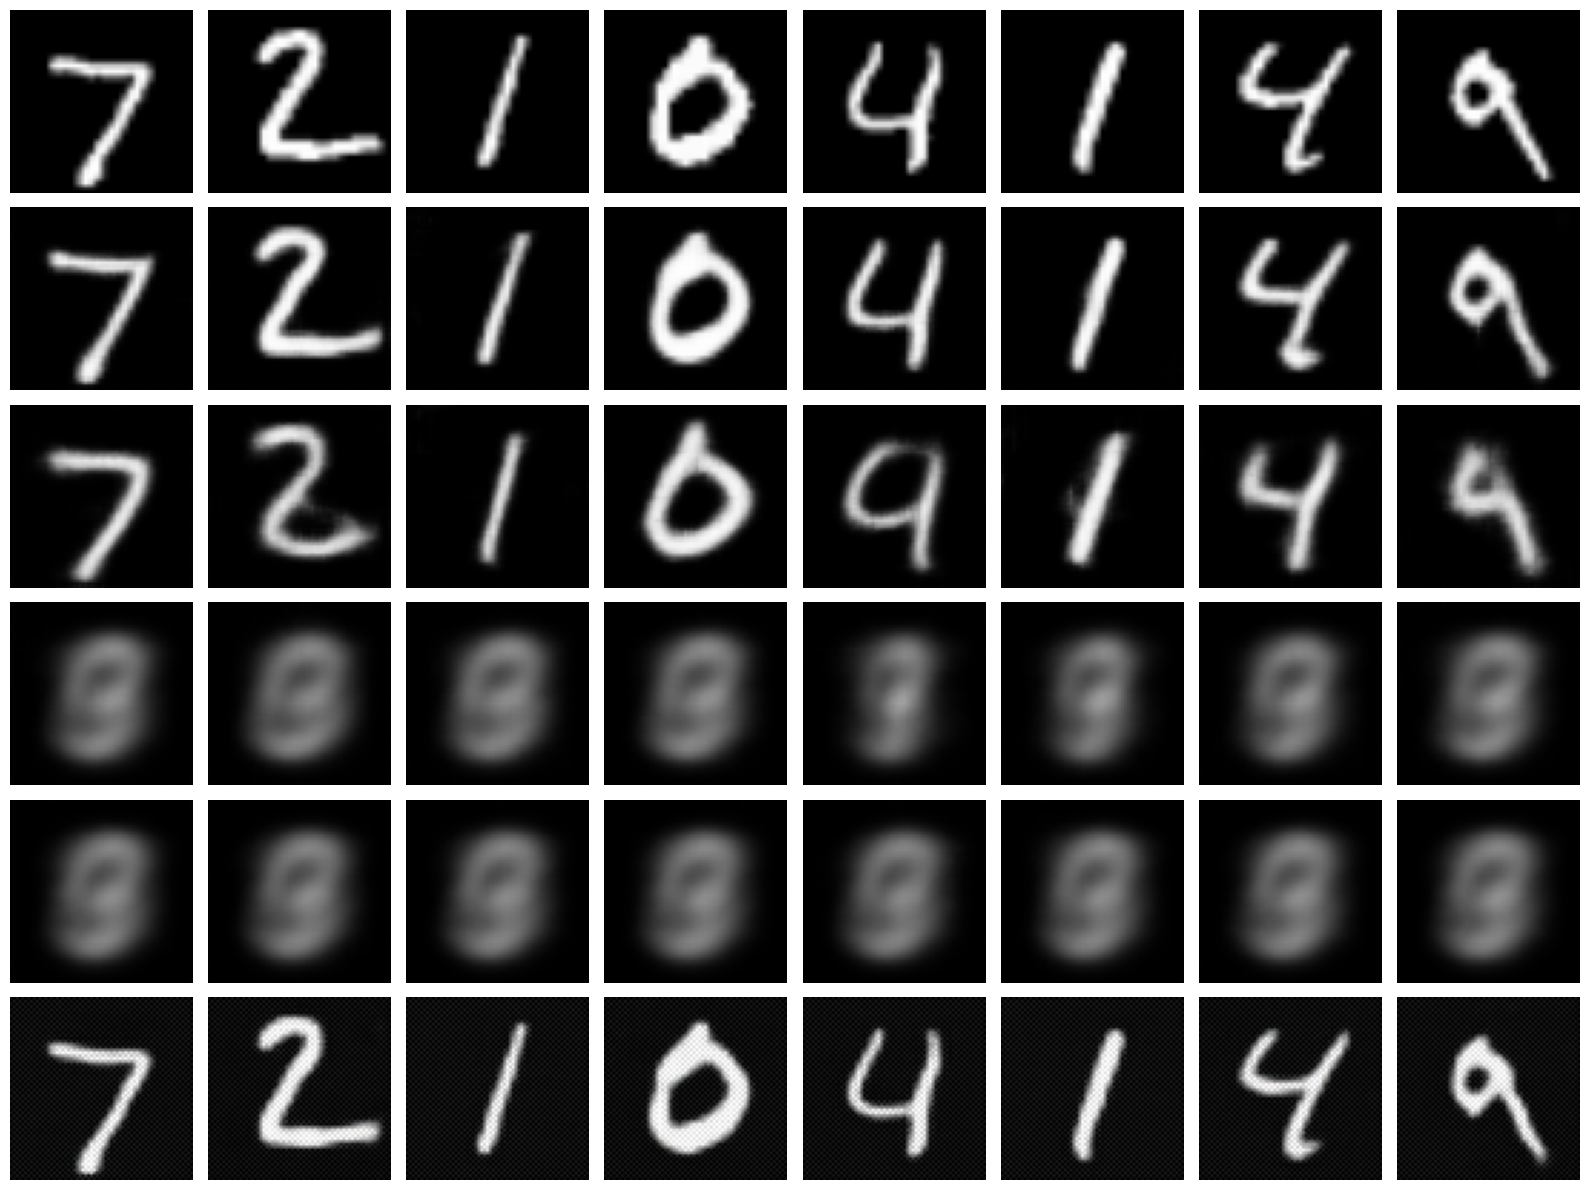

In [ ]:
# Reconstructions comparison
test_batch = next(iter(test_loader))[0][:8].to(device)

n_models = len(results)
fig, axes = plt.subplots(n_models + 1, 8, figsize=(16, 2*(n_models+1)))

# Original
for i in range(8):
    axes[0, i].imshow(test_batch[i].cpu().permute(1,2,0))
    axes[0, i].axis('off')
axes[0, 0].set_ylabel('Original', fontsize=12)

# Each model's reconstruction
for row, (name, data) in enumerate(results.items(), 1):
    model = data['model']
    model.eval()
    with torch.no_grad():
        recon, _, _ = model(test_batch)

    for i in range(8):
        axes[row, i].imshow(recon[i].cpu().permute(1,2,0))
        axes[row, i].axis('off')
    axes[row, 0].set_ylabel(name.replace('_', '='), fontsize=12)

plt.tight_layout()
plt.savefig('reconstructions_comparison.png', dpi=150)
plt.show()

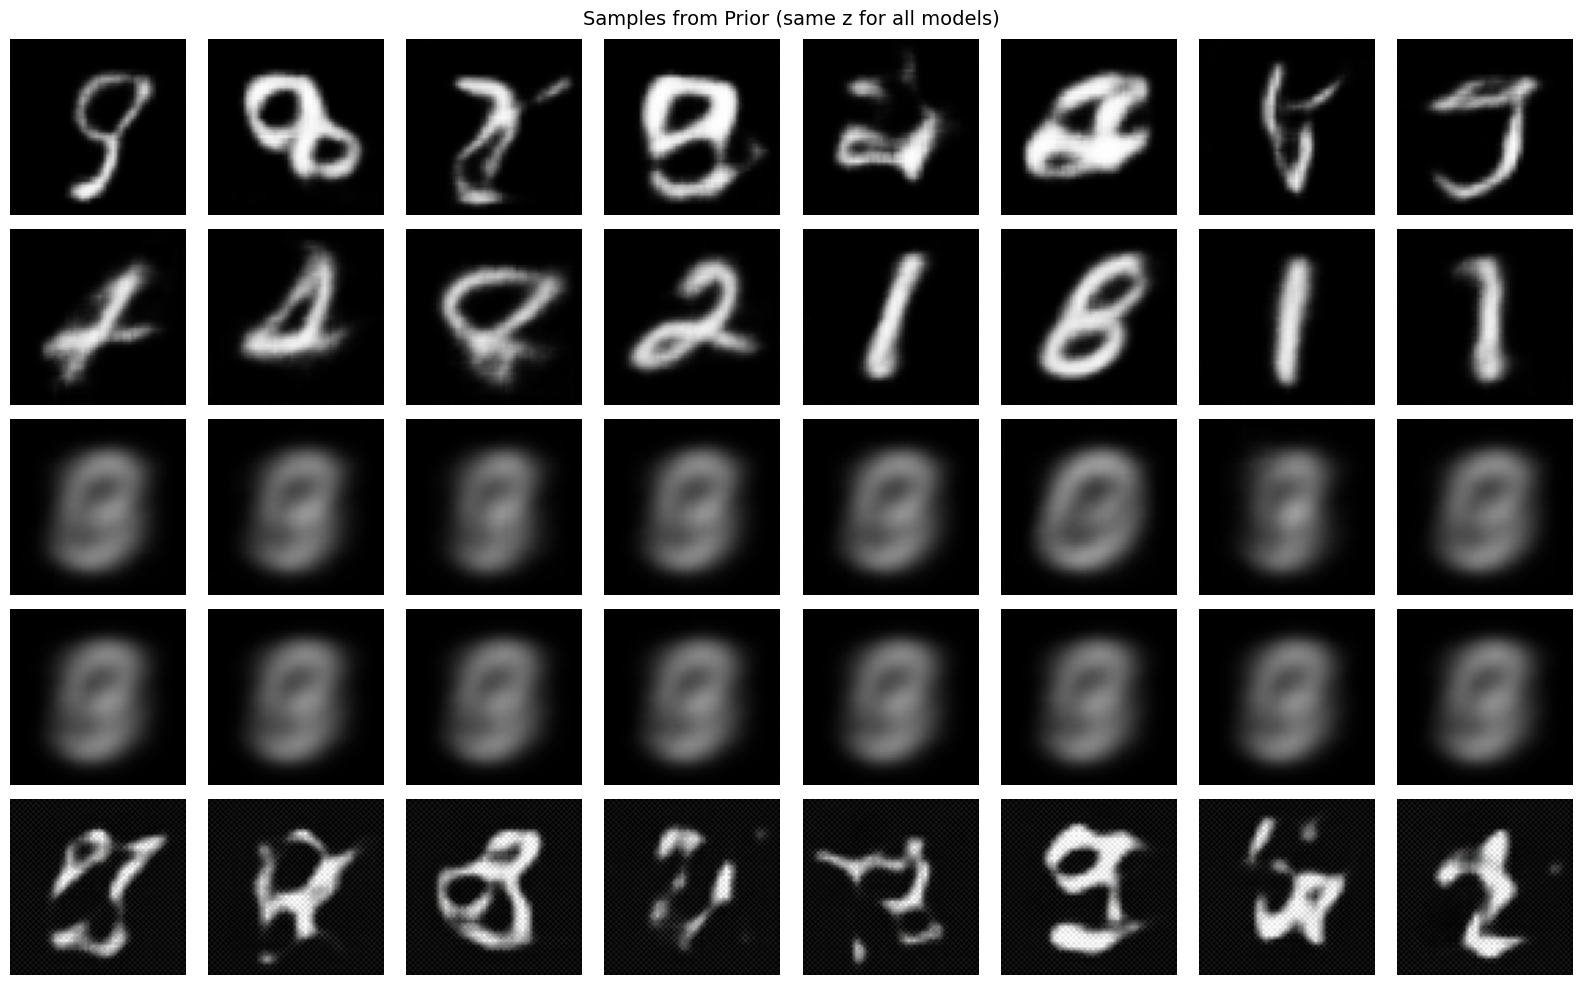

In [ ]:
# Samples from prior comparison
z = torch.randn(8, 128, device=device)

n_models = len(results)
fig, axes = plt.subplots(n_models, 8, figsize=(16, 2*n_models))

for row, (name, data) in enumerate(results.items()):
    model = data['model']
    model.eval()
    with torch.no_grad():
        samples = model.dec(model.fc_dec(z).view(-1, 256, 4, 4))

    for i in range(8):
        axes[row, i].imshow(samples[i].cpu().permute(1,2,0))
        axes[row, i].axis('off')
    axes[row, 0].set_ylabel(name.replace('_', '='), fontsize=12)

plt.suptitle('Samples from Prior (same z for all models)', fontsize=14)
plt.tight_layout()
plt.savefig('samples_comparison.png', dpi=150)
plt.show()

---
## Analysis

In [ ]:
# Find best β-VAE
beta_results = {k: v for k, v in results.items() if 'beta' in k}
bom_result = results['bom']

# Best by MSE
best_mse_beta = min(beta_results.items(), key=lambda x: x[1]['test']['mse'])
print(f"Best β-VAE by MSE: {best_mse_beta[0]} (MSE={best_mse_beta[1]['test']['mse']:.4f})")
print(f"BOM-VAE MSE: {bom_result['test']['mse']:.4f}")
print()

# Best by balanced score (low MSE, moderate KL, high sharp)
def balanced_score(t):
    # Lower MSE is better (invert)
    # KL around 50-150 is good (penalty for too low or too high)
    # Higher sharpness is better
    mse_score = 1.0 / (t['mse'] + 0.001)
    kl_score = 1.0 / (abs(t['kl'] - 100) + 10)  # Peak at KL=100
    sharp_score = t['sharp']
    return mse_score * kl_score * sharp_score

best_balanced_beta = max(beta_results.items(), key=lambda x: balanced_score(x[1]['test']))
print(f"Best β-VAE by balanced score: {best_balanced_beta[0]}")
print(f"  Score: {balanced_score(best_balanced_beta[1]['test']):.4f}")
print(f"BOM-VAE balanced score: {balanced_score(bom_result['test']):.4f}")

Best β-VAE by MSE: beta_0.0001 (MSE=0.0035)
BOM-VAE MSE: 0.0054

Best β-VAE by balanced score: beta_0.0001
  Score: 0.0899
BOM-VAE balanced score: 0.7390


## Latent Space Quality Test

If BOM's higher KL (115 vs 45 nats) contains useful information, a classifier trained on the latent vectors should perform better.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def extract_latents(model, loader, device):
    """Extract latent μ vectors and labels."""
    model.eval()
    all_mu, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            h = model.enc(x).view(x.size(0), -1)
            mu = model.fc_mu(h)
            all_mu.append(mu.cpu().numpy())
            all_labels.append(y.numpy())

    return np.vstack(all_mu), np.concatenate(all_labels)

def test_latent_classifier(model, train_loader, test_loader, device):
    """Train logistic regression on latents, return test accuracy."""
    train_mu, train_y = extract_latents(model, train_loader, device)
    test_mu, test_y = extract_latents(model, test_loader, device)

    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(train_mu, train_y)

    train_acc = accuracy_score(train_y, clf.predict(train_mu))
    test_acc = accuracy_score(test_y, clf.predict(test_mu))

    return train_acc, test_acc

print("="*70)
print("LATENT SPACE QUALITY TEST")
print("="*70)
print("Training linear classifiers on latent representations (μ vectors)")
print("Higher accuracy = more useful information in latent space\n")
print(f"{'Method':<20} {'Train Acc':>12} {'Test Acc':>12}")
print("-"*70)

classifier_results = {}
for name, data in results.items():
    train_acc, test_acc = test_latent_classifier(data['model'], train_loader, test_loader, device)
    classifier_results[name] = {'train_acc': train_acc, 'test_acc': test_acc}
    print(f"{name:<20} {train_acc:>12.4f} {test_acc:>12.4f}")

print("-"*70)

# Summary
best_beta_clf = max([(k, v) for k, v in classifier_results.items() if 'beta' in k],
                     key=lambda x: x[1]['test_acc'])
bom_clf = classifier_results['bom']

print(f"\nBest β-VAE: {best_beta_clf[0]} ({best_beta_clf[1]['test_acc']:.4f})")
print(f"BOM-VAE:    {bom_clf['test_acc']:.4f}")

if bom_clf['test_acc'] > best_beta_clf[1]['test_acc']:
    improvement = (bom_clf['test_acc'] - best_beta_clf[1]['test_acc']) / best_beta_clf[1]['test_acc'] * 100
    print(f"\n✓ BOM latents are {improvement:.1f}% more useful for classification!")
elif bom_clf['test_acc'] == best_beta_clf[1]['test_acc']:
    print(f"\n= BOM and best β-VAE tied.")
else:
    diff = (best_beta_clf[1]['test_acc'] - bom_clf['test_acc']) / bom_clf['test_acc'] * 100
    print(f"\nβ-VAE latents performed {diff:.1f}% better.")

LATENT SPACE QUALITY TEST
Training linear classifiers on latent representations (μ vectors)
Higher accuracy = more useful information in latent space

Method                  Train Acc     Test Acc
----------------------------------------------------------------------
beta_0.0001                0.9510       0.9503
beta_0.001                 0.9709       0.9724
beta_0.01                  0.7174       0.7323
beta_0.1                   0.1455       0.1506
bom                        0.9278       0.9296
----------------------------------------------------------------------

Best β-VAE: beta_0.001 (0.9724)
BOM-VAE:    0.9296

β-VAE latents performed 4.6% better.


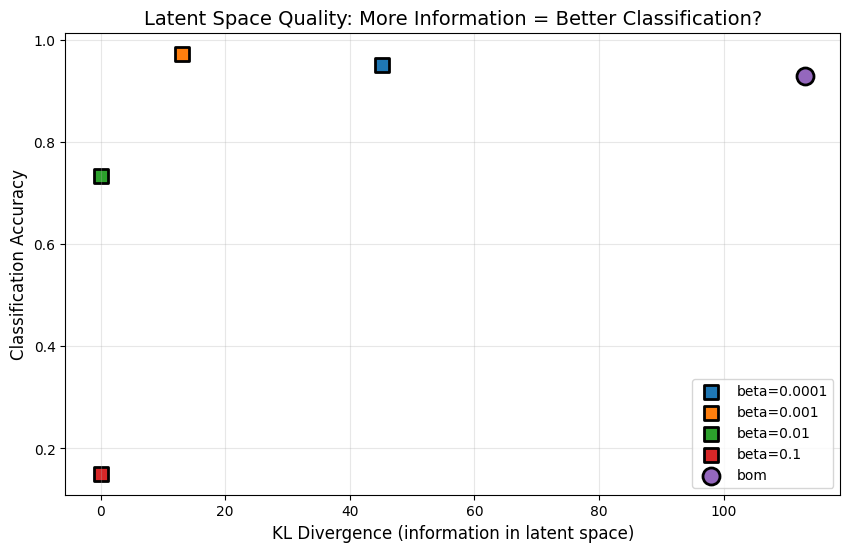

In [ ]:
# Visualize classifier accuracy vs KL
plt.figure(figsize=(10, 6))

for name, data in results.items():
    kl = data['test']['kl']
    acc = classifier_results[name]['test_acc']
    marker = 'o' if 'bom' in name else 's'
    size = 150 if 'bom' in name else 100
    plt.scatter(kl, acc, s=size, marker=marker, label=name.replace('_', '='), edgecolors='black', linewidths=2)

plt.xlabel('KL Divergence (information in latent space)', fontsize=12)
plt.ylabel('Classification Accuracy', fontsize=12)
plt.title('Latent Space Quality: More Information = Better Classification?', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('latent_quality.png', dpi=150)
plt.show()

In [ ]:
# Final summary table
print("\n" + "="*80)
print("COMPLETE RESULTS SUMMARY")
print("="*80)
print(f"{'Method':<15} {'MSE':>8} {'KL':>8} {'Sharp':>8} {'Clf Acc':>10} {'Balanced':>10}")
print("-"*80)

for name, data in results.items():
    t = data['test']
    acc = classifier_results[name]['test_acc']
    bal = balanced_score(t)
    print(f"{name:<15} {t['mse']:>8.4f} {t['kl']:>8.1f} {t['sharp']:>8.4f} {acc:>10.4f} {bal:>10.4f}")

print("-"*80)


COMPLETE RESULTS SUMMARY
Method               MSE       KL    Sharp    Clf Acc   Balanced
--------------------------------------------------------------------------------
beta_0.0001       0.0035     45.1   0.0264     0.9503     0.0899
beta_0.001        0.0133     13.1   0.0239     0.9724     0.0173
beta_0.01         0.0558      0.1   0.0109     0.7323     0.0017
beta_0.1          0.0567      0.0   0.0105     0.1506     0.0017
bom               0.0054    113.0   0.1082     0.9296     0.7390
--------------------------------------------------------------------------------


In [ ]:
# Conclusion
print("\n" + "="*70)
print("CONCLUSION")
print("="*70)
print("""
β-VAE requires tuning β to balance reconstruction vs regularization.
Different β values give different tradeoffs:
- Low β (0.0001): Good MSE, but KL may collapse or explode
- High β (0.1): Controlled KL, but poor reconstruction

BOM-VAE automatically finds a balanced solution:
- No β hyperparameter to tune
- Adaptive squeeze finds the Pareto frontier
- All objectives are explicitly constrained

The key insight: BOM optimizes the WORST objective at each step,
preventing any single objective from being sacrificed.
""")


CONCLUSION

β-VAE requires tuning β to balance reconstruction vs regularization.
Different β values give different tradeoffs:
- Low β (0.0001): Good MSE, but KL may collapse or explode
- High β (0.1): Controlled KL, but poor reconstruction

BOM-VAE automatically finds a balanced solution:
- No β hyperparameter to tune
- Adaptive squeeze finds the Pareto frontier
- All objectives are explicitly constrained

The key insight: BOM optimizes the WORST objective at each step,
preventing any single objective from being sacrificed.

